# BerlinMOD Queries using Pyspark and PyMEOS

The objective of this notebook is to benchmark the performance of BerlinMOD queries using PyMEOS through Pyspark, utilizing different partitioning strategies. The first section of the notebook will focus in replicating the BerlinMOD tutorial from the PyMEOS documentation. Later on we will test the specific recommended queries.

### Go to file directory

In [1]:
cd '../../MobilityDB-BerlinMOD/BerlinMOD/BerlinMOD_0_005_CSV_new/berlinmodmeos'

/data/MobilityDB-BerlinMOD/BerlinMOD/BerlinMOD_0_005_CSV_new/berlinmodmeos


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
ls

ais_instants.csv        brussels_communes.csv           intspan.csv
ais_trips.csv           brussels_region.csv             textset.csv
ais_trips_longest.csv   floatspanset.csv                trip_instants.csv/
berlinmod_instants.csv  generate_ais_trips_longest.sql
berlinmod_trips.csv     generate_berlinmod_trips.sql


### Imports

In [3]:
from pymeos import *
from pymeos.plotters import *

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pysparkmeos.UDT.MeosDatatype import *
from pysparkmeos.partitions.grid.grid_partitioner import GridPartition
from pysparkmeos.utils.udt_appender import udt_append
from pysparkmeos.UDF.udf import *
from pysparkmeos.partitions.mobilityrdd import MobilityRDD


import random, datetime, os, sys
from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import pandas as pd
import shapely.geometry as shp

import matplotlib.pyplot as plt
import numpy as np
from shapely import wkb, box
from typing import Union

### Spark Initialization and Configuration

In [4]:
# Initialize PyMEOS
pymeos_initialize("UTC")

os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

#.config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("PySpark UDF Example with PyMEOS") \
    .master("local[*]") \
    .config("spark.default.parallelism", 50) \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# spark.sparkContext.setLogLevel("INFO")

# Append the UDT mapping to the PyMEOS classes
udt_append()

# Get the value of 'spark.default.parallelism'
default_parallelism = spark.sparkContext.getConf().get("spark.default.parallelism")
print(f"spark.default.parallelism: {default_parallelism}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/03 11:28:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


spark.default.parallelism: 50


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 46788)
Traceback (most recent call last):
  File "/usr/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.9/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 271, in accum_updates
    num_updates = read_int(self.rf

### Read DataFrames and show simple data

First read the DFs with the predefined schema. Note how we use the UDTs for data that is already preprocessed.

In [5]:
csvs = os.listdir()

In [6]:
berlinmodtrips = spark.read.csv('berlinmod_trips.csv', header=True, inferSchema=True)
berlinmodtrips.show(3)
berlinmodtrips.printSchema()
print(berlinmodtrips.count())

+------+-----+----------+-----+--------------------+
|tripid|vehid|       day|seqno|                trip|
+------+-----+----------+-----+--------------------+
|     1|    1|2020-06-01|    1|012E004E110F0000D...|
|     1|    1|2020-06-01|    2|012E004E110F0000A...|
|     1|    1|2020-06-01|    3|012E004E110F00004...|
+------+-----+----------+-----+--------------------+
only showing top 3 rows

root
 |-- tripid: integer (nullable = true)
 |-- vehid: integer (nullable = true)
 |-- day: date (nullable = true)
 |-- seqno: integer (nullable = true)
 |-- trip: string (nullable = true)

61


In [7]:
berlinmodinstants = spark.read.csv("berlinmod_instants.csv", header=True, inferSchema=True)
berlinmodinstants.show(3)
berlinmodinstants.printSchema()
print(berlinmodinstants.count())

+------+-----+----------+-----+--------------------+--------------------+
|tripid|vehid|       day|seqno|                geom|                   t|
+------+-----+----------+-----+--------------------+--------------------+
|     4|    4|2020-06-01|    1|SRID=3857;POINT(4...|2020-06-01 06:01:...|
|     4|    4|2020-06-01|    1|SRID=3857;POINT(4...|2020-06-01 06:01:...|
|     4|    4|2020-06-01|    1|SRID=3857;POINT(4...|2020-06-01 06:01:...|
+------+-----+----------+-----+--------------------+--------------------+
only showing top 3 rows

root
 |-- tripid: integer (nullable = true)
 |-- vehid: integer (nullable = true)
 |-- day: date (nullable = true)
 |-- seqno: integer (nullable = true)
 |-- geom: string (nullable = true)
 |-- t: timestamp (nullable = true)

85422


In [8]:
brucommunes = spark.read.csv("brussels_communes.csv", header=True, inferSchema=True)
brucommunes.show(3)
brucommunes.printSchema()
print(brucommunes.count())

+---+--------------------+----------+--------------------+
| id|                name|population|                geom|
+---+--------------------+----------+--------------------+
|  1|          Anderlecht|    118241|0103000020110F000...|
|  2|Auderghem - Oudergem|     33313|0103000020110F000...|
|  3|Berchem-Sainte-Ag...|     24701|0103000020110F000...|
+---+--------------------+----------+--------------------+
only showing top 3 rows

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- geom: string (nullable = true)

19


In [9]:
bruregion = spark.read.csv("brussels_region.csv", header=True, inferSchema=True)
bruregion.show(3)
bruregion.printSchema()
print(bruregion.count())

+--------------------+--------------------+
|                name|                geom|
+--------------------+--------------------+
|Région de Bruxell...|0103000020110F000...|
+--------------------+--------------------+

root
 |-- name: string (nullable = true)
 |-- geom: string (nullable = true)

1


In [10]:
@F.udf(returnType=TGeomPointSeqUDT())
def parse_trip(trip):
    pymeos_initialize()
    return TGeomPointSeqWrap.from_hexwkb(trip)

berlinmodtrips = berlinmodtrips.withColumn("traj", parse_trip("trip"))
berlinmodtrips.show()

+------+-----+----------+-----+--------------------+--------------------+
|tripid|vehid|       day|seqno|                trip|                traj|
+------+-----+----------+-----+--------------------+--------------------+
|     1|    1|2020-06-01|    1|012E004E110F0000D...|[POINT(493688.895...|
|     1|    1|2020-06-01|    2|012E004E110F0000A...|[POINT(490872.022...|
|     1|    1|2020-06-01|    3|012E004E110F00004...|[POINT(493688.895...|
|     1|    1|2020-06-01|    4|012E004E110F0000A...|[POINT(488044.195...|
|     1|    1|2020-06-02|    1|012E004E110F00003...|[POINT(493688.895...|
|     1|    1|2020-06-02|    2|012E004E110F00006...|[POINT(490872.022...|
|     1|    1|2020-06-03|    1|012E004E110F00002...|[POINT(493688.895...|
|     1|    1|2020-06-03|    2|012E004E110F00007...|[POINT(490872.022...|
|     1|    1|2020-06-04|    1|012E004E110F00003...|[POINT(493688.895...|
|     1|    1|2020-06-04|    2|012E004E110F00002...|[POINT(490872.022...|
|     2|    2|2020-06-01|    1|012E004

### Disassembling Trips

In [11]:
"""
records = trips.drop("trip", axis=1).copy()
records["geom"] = trips["trip"].apply(lambda tr: tr.values())
records["t"] = trips["trip"].apply(lambda tr: tr.timestamps())
records.head()
"""
@F.udf(returnType=ArrayType(GeometryUDT()))
def get_trip_values(traj: TGeomPointSeqUDT()):
    pymeos_initialize()
    values = []
    try:
        values = traj.values()
        return values
    except:
        return []

@F.udf(returnType=ArrayType(TimestampType()))
def get_ts_values(traj: TGeomPointSeqUDT()):
    pymeos_initialize()
    return traj.timestamps()

records = berlinmodtrips \
    .withColumn("geom", get_trip_values("traj")) \
    .withColumn("t", get_ts_values("traj")) \
    .select("tripid", "vehid", "day", "seqno", "geom", "t")

records.show(3)

+------+-----+----------+-----+--------------------+--------------------+
|tripid|vehid|       day|seqno|                geom|                   t|
+------+-----+----------+-----+--------------------+--------------------+
|     1|    1|2020-06-01|    1|[POINT (493688.89...|[2020-06-01 06:27...|
|     1|    1|2020-06-01|    2|[POINT (490872.02...|[2020-06-01 15:59...|
|     1|    1|2020-06-01|    3|[POINT (493688.89...|[2020-06-01 18:02...|
+------+-----+----------+-----+--------------------+--------------------+
only showing top 3 rows



Explode t and geom columns and order by ts.

In [12]:
records = records.withColumn("zipped", F.arrays_zip("geom", "t")).withColumn("zipped", F.explode("zipped")).select("tripid", "vehid", "day", "seqno", "zipped.geom", "zipped.t") #.orderBy("t")
records.show()

+------+-----+----------+-----+--------------------+--------------------+
|tripid|vehid|       day|seqno|                geom|                   t|
+------+-----+----------+-----+--------------------+--------------------+
|     1|    1|2020-06-01|    1|POINT (493688.895...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (493683.990...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (493679.086...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (493676.126...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (493671.543...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (493621.125...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (493621.125...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (493620.934...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (493603.178...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (493598.739...|2020-06-01 06:27:...|
|     1|    1|2020-06-01|    1|POINT (

Finally, we will write it in a CSV file, encoding first the geometries as HexWKB.

In [13]:
records = records.orderBy("t")
print(records.count())

85422


In [14]:
"""
records["geom"] = records["geom"].apply(partial(wkb.dumps, hex=True))
records.head()
"""
from shapely import to_wkb

@F.udf(returnType=StringType())
def get_wkb_hex(geoms: Point):
    return to_wkb(geoms, hex=True)

records = records.withColumn("partial", get_wkb_hex(F.col("geom")))
records.show()


+------+-----+----------+-----+--------------------+--------------------+--------------------+
|tripid|vehid|       day|seqno|                geom|                   t|             partial|
+------+-----+----------+-----+--------------------+--------------------+--------------------+
|     4|    4|2020-06-01|    1|POINT (479169.649...|2020-06-01 06:01:...|0101000000878C479...|
|     4|    4|2020-06-01|    1|POINT (479174.598...|2020-06-01 06:01:...|010100000007280D6...|
|     4|    4|2020-06-01|    1|POINT (479179.547...|2020-06-01 06:01:...|010100000087C3D23...|
|     4|    4|2020-06-01|    1|POINT (479180.191...|2020-06-01 06:01:...|010100000006103EC...|
|     4|    4|2020-06-01|    1|POINT (479184.928...|2020-06-01 06:01:...|0101000000FF9254B...|
|     4|    4|2020-06-01|    1|POINT (479194.400...|2020-06-01 06:01:...|0101000000F298819...|
|     4|    4|2020-06-01|    1|POINT (479194.485...|2020-06-01 06:01:...|01010000001EE1B4F...|
|     4|    4|2020-06-01|    1|POINT (479198.885..

In [15]:
# records.write.csv("trip_instants.csv", header=True, mode="overwrite")

### Clipping Trips To Geometries

+--------------------+--------------------+--------------------+
|                name|                geom|            geomProc|
+--------------------+--------------------+--------------------+
|Région de Bruxell...|0103000020110F000...|POLYGON ((472413....|
+--------------------+--------------------+--------------------+



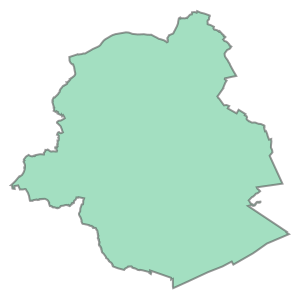

In [45]:
from shapely import from_wkb

@F.udf(returnType=GeometryUDT())
def wkb_to_geom(geom: str):
    return wkb.loads(geom, hex=True)

# First read the file about the brussels region and municipalities
bruregion = bruregion.withColumn("geomProc", wkb_to_geom("geom"))
bruregion.show()

brussels = gpd.GeoDataFrame(bruregion.toPandas(), geometry="geomProc")
brussels_geom = bruregion.collect()[0][2]
brussels_geom

#brussels = gpd.GeoDataFrame(brussels, geometry="geom")
#brussels_geom = brussels["geom"][0]
#brussels


In [17]:
#communes = pd.read_csv(
#    "./data/communes.csv", converters={"geom": partial(wkb.loads, hex=True)}
#)

communescolor = [
    "#00ff00",
    "#ff00ff",
    "#007fff",
    "#ff7f00",
    "#7fbf7f",
    "#47139e",
    "#ad0414",
    "#d981f9",
    "#138014",
    "#f4fc2c",
    "#00ffff",
    "#00ff7f",
    "#c04d7c",
    "#85eaf3",
    "#85d601",
    "#fca880",
    "#0000ff",
    "#019d92",
    "#907817",
]

brucommunes = brucommunes.withColumn("geomProc", wkb_to_geom("geom"))

brucommunes.show()

communes = gpd.GeoDataFrame(brucommunes.drop("geom").toPandas(), geometry="geomProc")
communes['color'] = communescolor
communes

+---+--------------------+----------+--------------------+--------------------+
| id|                name|population|                geom|            geomProc|
+---+--------------------+----------+--------------------+--------------------+
|  1|          Anderlecht|    118241|0103000020110F000...|POLYGON ((476959....|
|  2|Auderghem - Oudergem|     33313|0103000020110F000...|POLYGON ((497620....|
|  3|Berchem-Sainte-Ag...|     24701|0103000020110F000...|POLYGON ((477788....|
|  4|           Etterbeek|    176545|0103000020110F000...|POLYGON ((489804....|
|  5|               Evere|     47414|0103000020110F000...|POLYGON ((492771....|
|  6|      Forest - Vorst|     40394|0103000020110F000...|POLYGON ((479909....|
|  7|           Ganshoren|     55746|0103000020110F000...|POLYGON ((478477....|
|  8|    Ixelles - Elsene|     24596|0106000020110F000...|MULTIPOLYGON (((4...|
|  9|               Jette|     86244|0103000020110F000...|POLYGON ((481479....|
| 10|          Koekelberg|     51933|010

,id,name,population,geomProc,color
0,1,Anderlecht,118241,"POLYGON ((476959.746 6593981.357, 476965.401 6...",#00ff00
1,2,Auderghem - Oudergem,33313,"POLYGON ((497620.844 6584185.646, 497856.652 6...",#ff00ff
2,3,Berchem-Sainte-Agathe - Sint-Agatha-Berchem,24701,"POLYGON ((477788.720 6599192.996, 477782.631 6...",#007fff
3,4,Etterbeek,176545,"POLYGON ((489804.602 6593678.230, 489685.067 6...",#ff7f00
4,5,Evere,47414,"POLYGON ((492771.667 6597070.173, 492633.519 6...",#7fbf7f
5,6,Forest - Vorst,40394,"POLYGON ((479909.268 6585570.952, 479881.003 6...",#47139e
6,7,Ganshoren,55746,"POLYGON ((478477.209 6600450.089, 478499.863 6...",#ad0414
7,8,Ixelles - Elsene,24596,"MULTIPOLYGON (((487496.626 6592340.790, 487544...",#d981f9
8,9,Jette,86244,"POLYGON ((481479.217 6597749.534, 481526.350 6...",#138014
9,10,Koekelberg,51933,"POLYGON ((480236.024 6597825.520, 480178.160 6...",#f4fc2c


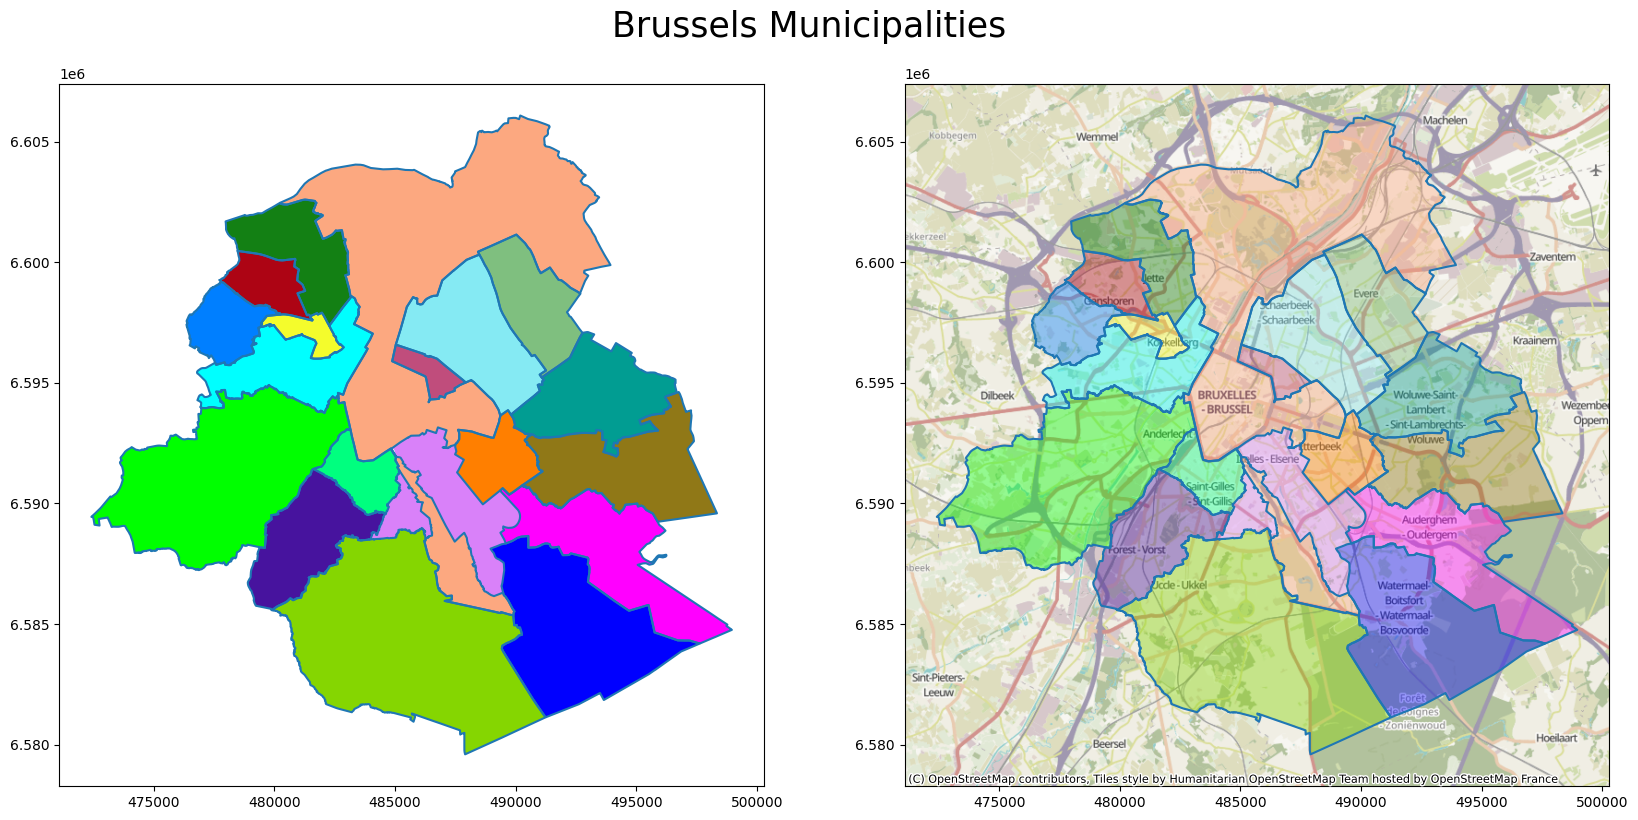

In [18]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
communes.plot(color=communes["color"], ax=axes[0])
communes.exterior.plot(ax=axes[0])
communes.plot(color=communes["color"], ax=axes[1], alpha=0.4)
communes.exterior.plot(ax=axes[1])
cx.add_basemap(axes[1])
_ = plt.suptitle("Brussels Municipalities", size=25, y=0.92)

### BerlinMOD Trajectories over Brussels

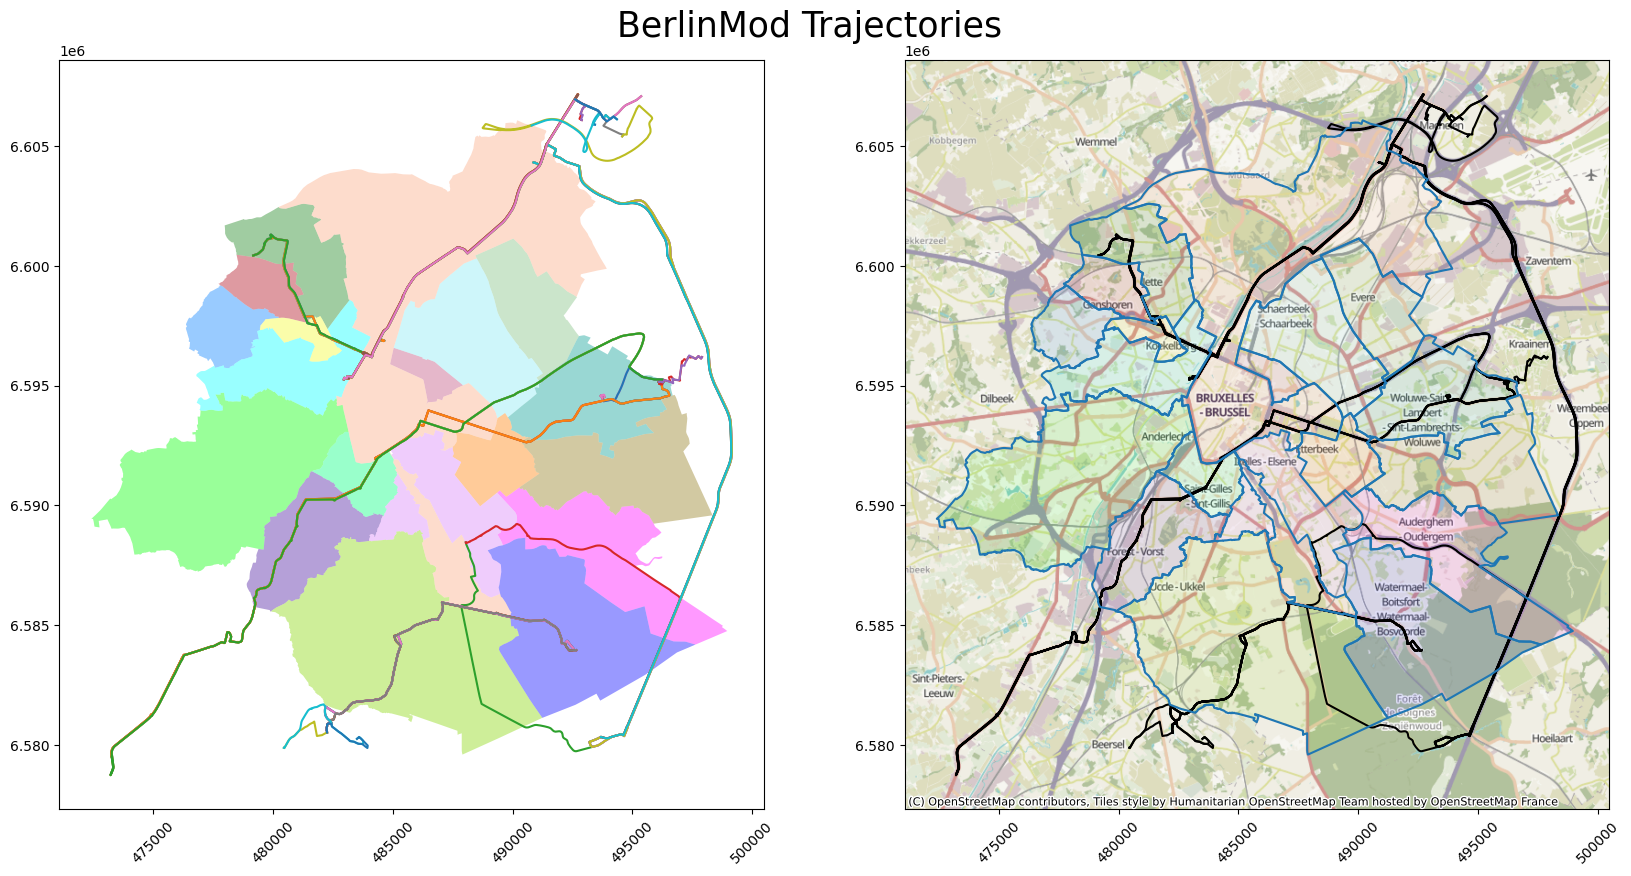

In [19]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
communes.plot(color=communes["color"], ax=axes[0], alpha=0.4)

for traj in berlinmodtrips.toLocalIterator():
    traj.traj.plot(axes=axes[0], show_markers=False, show_grid=False)
    traj.traj.plot(axes=axes[1], color="black", show_markers=False, show_grid=False)


#TemporalPointSequencePlotter.plot_sequences_xy(
#    berlinmodtrips["traj"], axes=axes[0], show_markers=False, show_grid=False
#)

communes.plot(color=communes["color"], ax=axes[1], alpha=0.1)
communes.exterior.plot(ax=axes[1])

#TemporalPointSequencePlotter.plot_sequences_xy(
#    trips["trip"], axes=axes[1], color="black", show_markers=False, show_grid=False
#)

cx.add_basemap(axes[1])

_ = plt.suptitle("BerlinMod Trajectories", size=25, y=0.92)

Split into sections inside and outside of Brussels.

In [38]:
@F.udf(returnType=TGeomPointSeqSetUDT())
def trip_at(trip, geom):
    pymeos_initialize()
    return trip.at(from_wkt(geom))

@F.udf(returnType=TGeomPointSeqSetUDT())
def trip_minus(trip, geom):
    pymeos_initialize()
    return trip.minus(from_wkt(geom))

brusselsinout = berlinmodtrips.withColumn("inside", trip_at("traj", F.lit(to_wkt(brussels_geom)))).withColumn("outside", trip_minus("traj", F.lit(to_wkt(brussels_geom))))
brusselsinout.show(3)

+------+-----+----------+-----+--------------------+--------------------+--------------------+--------------------+
|tripid|vehid|       day|seqno|                trip|                traj|              inside|             outside|
+------+-----+----------+-----+--------------------+--------------------+--------------------+--------------------+
|     1|    1|2020-06-01|    1|012E004E110F0000D...|[POINT(493688.895...|{[POINT(495767.86...|{[POINT(493688.89...|
|     1|    1|2020-06-01|    2|012E004E110F0000A...|[POINT(490872.022...|{[POINT(490872.02...|{(POINT(491346.76...|
|     1|    1|2020-06-01|    3|012E004E110F00004...|[POINT(493688.895...|{[POINT(490458.61...|{[POINT(493688.89...|
+------+-----+----------+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



Visualize the split.

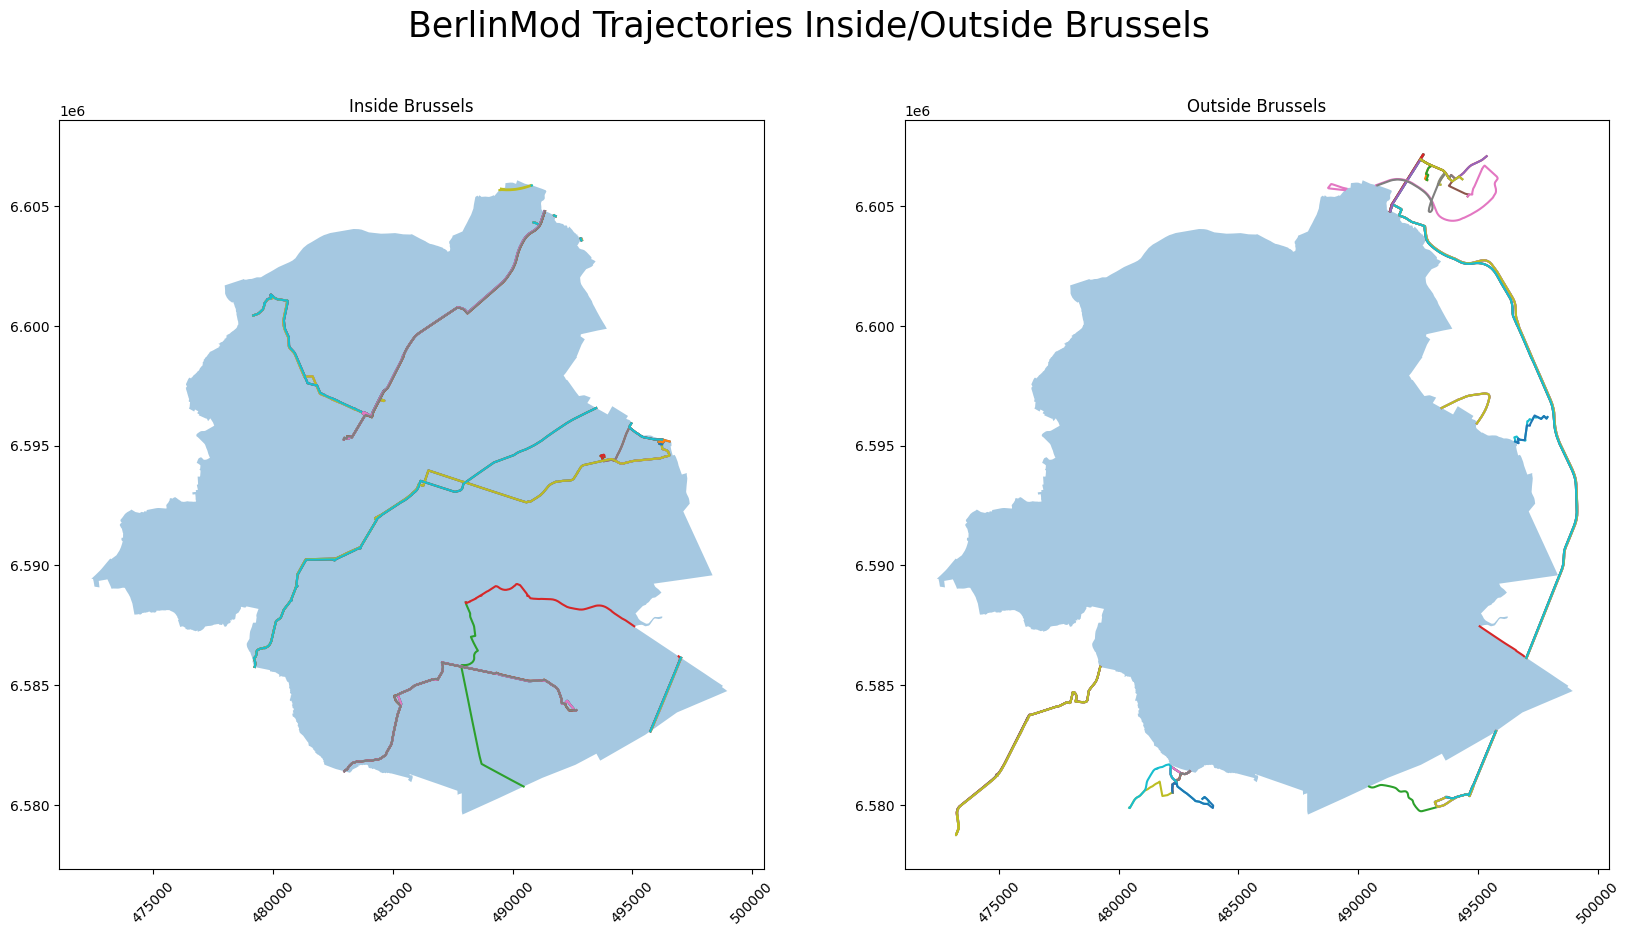

In [50]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].set_title("Inside Brussels")
brussels.plot(ax=axes[0], alpha=0.4)
for t in brusselsinout.toLocalIterator():
    if not t.inside:
        continue
    t = t.inside
    
    traj = t
    if isinstance(traj, TGeomPointSeq):
        TemporalPointSequencePlotter.plot_xy(
            traj, axes=axes[0], show_markers=False, show_grid=False
        )
    else:
        TemporalPointSequenceSetPlotter.plot_xy(
            traj, axes=axes[0], show_markers=False, show_grid=False
        )

axes[1].set_title("Outside Brussels")
brussels.plot(ax=axes[1], alpha=0.4)

for t in brusselsinout.toLocalIterator():
    if not t.outside:
        continue
    t = t.outside
    
    traj = t
    if isinstance(traj, TGeomPointSeq):
        TemporalPointSequencePlotter.plot_xy(
            traj, axes=axes[1], show_markers=False, show_grid=False
        )
    else:
        TemporalPointSequenceSetPlotter.plot_xy(
            traj, axes=axes[1], show_markers=False, show_grid=False
        )            

axes[0].set_xlim(
    min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]),
    max(axes[0].get_xlim()[1], axes[1].get_xlim()[1]),
)
axes[0].set_ylim(
    min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]),
    max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]),
)

_ = plt.suptitle("BerlinMod Trajectories Inside/Outside Brussels", size=25)

Compute trajectory and distance each trip traverses.

In [52]:
commune_trajectories = berlinmodtrips

brucommunes.show()
"""
commune_trajectories = trips.copy()
for _, row in communes.iterrows():
    commune_trajectories[f'{row["name"]}-trajectory'] = commune_trajectories[
        "trip"
    ].apply(lambda tr: tr.at(row["geom"]))
    commune_trajectories[f'{row["name"]}-distance'] = commune_trajectories[
        f'{row["name"]}-trajectory'
    ].apply(lambda tr: tr.length() if tr else 0)
commune_trajectories.head()
"""

+---+--------------------+----------+--------------------+--------------------+
| id|                name|population|                geom|            geomProc|
+---+--------------------+----------+--------------------+--------------------+
|  1|          Anderlecht|    118241|0103000020110F000...|POLYGON ((476959....|
|  2|Auderghem - Oudergem|     33313|0103000020110F000...|POLYGON ((497620....|
|  3|Berchem-Sainte-Ag...|     24701|0103000020110F000...|POLYGON ((477788....|
|  4|           Etterbeek|    176545|0103000020110F000...|POLYGON ((489804....|
|  5|               Evere|     47414|0103000020110F000...|POLYGON ((492771....|
|  6|      Forest - Vorst|     40394|0103000020110F000...|POLYGON ((479909....|
|  7|           Ganshoren|     55746|0103000020110F000...|POLYGON ((478477....|
|  8|    Ixelles - Elsene|     24596|0106000020110F000...|MULTIPOLYGON (((4...|
|  9|               Jette|     86244|0103000020110F000...|POLYGON ((481479....|
| 10|          Koekelberg|     51933|010

'\ncommune_trajectories = trips.copy()\nfor _, row in communes.iterrows():\n    commune_trajectories[f\'{row["name"]}-trajectory\'] = commune_trajectories[\n        "trip"\n    ].apply(lambda tr: tr.at(row["geom"]))\n    commune_trajectories[f\'{row["name"]}-distance\'] = commune_trajectories[\n        f\'{row["name"]}-trajectory\'\n    ].apply(lambda tr: tr.length() if tr else 0)\ncommune_trajectories.head()\n'